It is highly recommended to use a powerful **GPU**, you can use it for free uploading this notebook to [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb).
<table align="center">
 <td align="center"><a target="_blank" href="https://colab.research.google.com/github/ezponda/intro_deep_learning/blob/main/class/Fundamentals/IMBD_sentiment_binary_classification.ipynb">
        <img src="https://i.ibb.co/2P3SLwK/colab.png"  style="padding-bottom:5px;" />Run in Google Colab</a></td>
  <td align="center"><a target="_blank" href="https://github.com/ezponda/intro_deep_learning/blob/main/class/Fundamentals/IMBD_sentiment_binary_classification.ipynb">
        <img src="https://i.ibb.co/xfJbPmL/github.png"  height="70px" style="padding-bottom:5px;"  />View Source on GitHub</a></td>
</table>

# Classification Example
 Two-class classification, or binary classification, may be the most widely applied kind of machine-learning problem. In this example, you’ll learn to classify movie reviews as positive or negative, based on the text content of the reviews.


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

## The Dataset: The IMDB dataset
We’ll work with the IMDB dataset: a set of 50,000 highly polarized reviews from the Internet Movie Database. They’re split into 25,000 reviews for training and 25,000 reviews for testing, each set consisting of 50% negative and 50% positive reviews. The  parameter `num_words` controls how many words different we want to use.

In [2]:
from tensorflow.keras.datasets import imdb
num_words = 10000
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=num_words)
print(train_data[0])

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Users/aezponda/opt/anaconda3/envs/dl/lib/python3.6/site-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])


[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


/Users/aezponda/opt/anaconda3/envs/dl/lib/python3.6/site-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [3]:
# Transform word_id to word and reverse
word2int = imdb.get_word_index()
word2int = {w: i+3 for w, i in word2int.items()}
word2int["<PAD>"] = 0
word2int["<START>"] = 1
word2int["<UNK>"] = 2
word2int["<UNUSED>"] = 3
int2word = {i: w for w, i in word2int.items()}
num_words = num_words+3

For transforming an id-sequence to a phrase use get_words

In [4]:
def get_words(sentence, int2word):
    return ' '.join([int2word.get(i,'<UNK>') for i in sentence])
get_words(train_data[0], int2word)

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

## Data Preprocessing

You need to convert your raw text to an appropriate input to a sequential model 

In [6]:
def vectorize_text_sentence(text, word2int):
    tokens = text.split(' ')
    tokens_id = [word2int.get(tk,2) for tk in tokens]
    return tokens_id

text = get_words(train_data[0], int2word)
print(text)
print(vectorize_sentence(text, word2int))

<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wha

We are going to use a bag of words model. BoW is a simplifying representation used in natural language processing. In this model, a text (such as a sentence or a document) is represented as the Each key is the word, and each value is the frequency of occurrences of that word in the given text document.

- **Input document**: `"John likes to watch movies Mary likes movies too"`
- **BoW**: `{'John': 0.11, 'likes': 0.22, 'to': 0.11, 'watch': 0.11, 'movies': 0.22, 'Mary': 0.11, 'too': 0.11}`

After that, we convert every BoW to a vector of `dim=num_words` with `vectorize_sequences`

In [10]:
from collections import Counter


def get_bag_of_words(sequence, norm=True):
    word_count = Counter(sequence)
    if norm:
        total = sum(word_count.values())
        word_freq = {w: n / total for w, n in word_count.items()}
        return word_freq
    else:
        return dict(word_count.items())


def vectorize_sequence(sequence, num_words, norm=True):
    vec = np.zeros(num_words)
    bow = get_bag_of_words(sequence, norm)
    for w, freq in bow.items():
        if w < num_words:
            vec[w] = freq
    return vec


def vectorize_sequences(sequences, num_words=num_words, norm=True):
    """Creates an all-zero matrix of shape (len(sequences), num_words)"""
    results = np.zeros((len(sequences), num_words))
    for i, sequence in enumerate(sequences):
        results[i, :] = vectorize_sequence(sequence, num_words, norm)
    return results


text_example = "John likes to watch movies Mary likes movies too"
print('text_example', text_example)
text_sequence = text_example.split()
print('text splitted', text_sequence)
bag_of_words = get_bag_of_words(text_sequence)
print('bag_of_words', bag_of_words)
print('bag_of_words norm=False', get_bag_of_words(text_sequence, norm=False))

text_example John likes to watch movies Mary likes movies too
text splitted ['John', 'likes', 'to', 'watch', 'movies', 'Mary', 'likes', 'movies', 'too']
bag_of_words {'John': 0.1111111111111111, 'likes': 0.2222222222222222, 'to': 0.1111111111111111, 'watch': 0.1111111111111111, 'movies': 0.2222222222222222, 'Mary': 0.1111111111111111, 'too': 0.1111111111111111}
bag_of_words norm=False {'John': 1, 'likes': 2, 'to': 1, 'watch': 1, 'movies': 2, 'Mary': 1, 'too': 1}


In [11]:
x_train = vectorize_sequences(train_data, num_words=num_words)
x_test = vectorize_sequences(test_data, num_words=num_words)
y_train =np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')
x_train.shape, y_train.shape

((25000, 10003), (25000,))

## Define and train a model 

Define, compile and fit your NN model

1. You can use the [Functional API](https://keras.io/guides/functional_api/):

You need to start with an input data entry:
```python    
    inputs = keras.Input(shape=(8,))
    layer_1 = layers.Dense(...)(inputs)
```

and the network outputs:
```python
outputs = layers.Dense(...)(previous_layer)
model = keras.Model(inputs=inputs, outputs=outputs)
```

2. Or you can use [Sequential API](https://keras.io/guides/sequential_model/)

```python
model = keras.Sequential(name='example_model')
model.add(layers.Dense(..., input_shape=(8,))
model.add(...
```

First try with only one hidden layer and see the results.

In [ ]:
model = ...


In [ ]:
inputs = tf.keras.Input(shape=(...,), name='input_layer')  # entrada

# Model definition
model = keras.Model(inputs=..., outputs=...)

In [18]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
history = model.fit(x_train, y_train, validation_split=0.25, epochs= 5, batch_size=32)

Epoch 1/5
586/586 [==============================] - 5s 7ms/step - loss: 0.5821 - accuracy: 0.6972 - val_loss: 0.2856 - val_accuracy: 0.8834
Epoch 2/5
586/586 [==============================] - 3s 6ms/step - loss: 0.2501 - accuracy: 0.9058 - val_loss: 0.2618 - val_accuracy: 0.8933
Epoch 3/5
586/586 [==============================] - 3s 6ms/step - loss: 0.1714 - accuracy: 0.9386 - val_loss: 0.2732 - val_accuracy: 0.8886
Epoch 4/5
586/586 [==============================] - 3s 5ms/step - loss: 0.1370 - accuracy: 0.9536 - val_loss: 0.3069 - val_accuracy: 0.8810
Epoch 5/5
586/586 [==============================] - 3s 5ms/step - loss: 0.1037 - accuracy: 0.9655 - val_loss: 0.3080 - val_accuracy: 0.8925


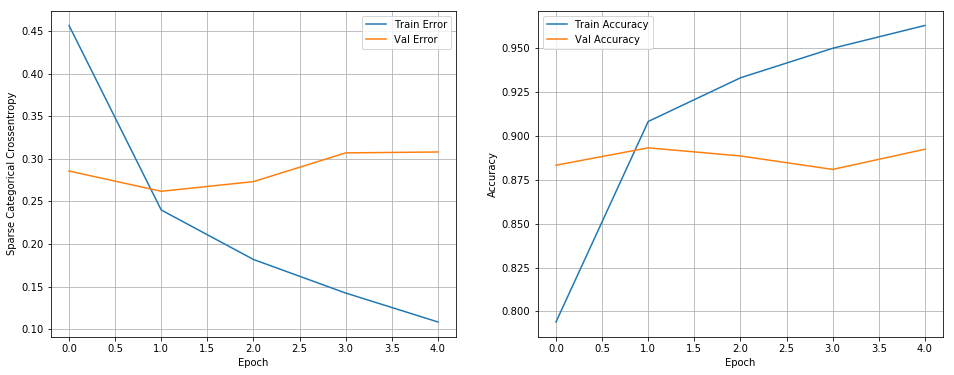

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
def show_loss_accuracy_evolution(hist):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Sparse Categorical Crossentropy')
    ax1.plot(hist['epoch'], hist['loss'], label='Train Error')
    ax1.plot(hist['epoch'], hist['val_loss'], label = 'Val Error')
    ax1.grid()
    ax1.legend()

    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.plot(hist['epoch'], hist['accuracy'], label='Train Accuracy')
    ax2.plot(hist['epoch'], hist['val_accuracy'], label = 'Val Accuracy')
    ax2.grid()
    ax2.legend()

    plt.show()
    
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
show_loss_accuracy_evolution(hist)

### Evaluate the model
You need to obtain a Test Accuracy > 0.85. Try to get more than 0.9!

In [20]:
results = model.evaluate(x_test, y_test, verbose=1)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

782/782 [==============================] - 3s 3ms/step - loss: 0.3476 - accuracy: 0.8760
Test Loss: 0.3476182520389557
Test Accuracy: 0.8759999871253967


### Making predictioins with new data

In [23]:
reviews = ['the film was really bad and i am very disappointed',
           'The film was very funny entertaining and good we had a great time . brilliant film',
           'this film was just brilliant',
           'the movie is not bad',
           'the movie is not bad I like it'
]
sequences = [vectorize_text_sentence(review.lower(), word2int)
             for review in reviews]

x_pred = vectorize_sequences(sequences, num_words=num_words)
np.round(model.predict(x_pred), 4)# model.predict(x_pred) > 0.5

array([[1.000e-04],
       [1.000e+00],
       [9.999e-01],
       [1.000e-04],
       [5.800e-03]], dtype=float32)

In [24]:
1.0*(model.predict(x_pred) > 0.5)

array([[0.],
       [1.],
       [1.],
       [0.],
       [0.]])

### Question 1: Repeat the process with unnormalized bag of words, compare results

In [26]:
x_train = vectorize_sequences(train_data, num_words=num_words, norm=False)
x_test = vectorize_sequences(test_data, num_words=num_words, norm=False)
y_train =np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')
x_train.shape, y_train.shape

((25000, 10003), (25000,))

In [ ]:
model = ...

Epoch 1/5
586/586 [==============================] - 5s 8ms/step - loss: 0.4662 - accuracy: 0.7772 - val_loss: 0.3249 - val_accuracy: 0.8682
Epoch 2/5
586/586 [==============================] - 4s 6ms/step - loss: 0.1870 - accuracy: 0.9273 - val_loss: 0.2958 - val_accuracy: 0.8904
Epoch 3/5
586/586 [==============================] - 3s 6ms/step - loss: 0.1067 - accuracy: 0.9590 - val_loss: 0.3369 - val_accuracy: 0.8888
Epoch 4/5
586/586 [==============================] - 3s 5ms/step - loss: 0.0606 - accuracy: 0.9791 - val_loss: 0.4296 - val_accuracy: 0.8853
Epoch 5/5
586/586 [==============================] - 3s 5ms/step - loss: 0.0380 - accuracy: 0.9869 - val_loss: 0.4844 - val_accuracy: 0.8859


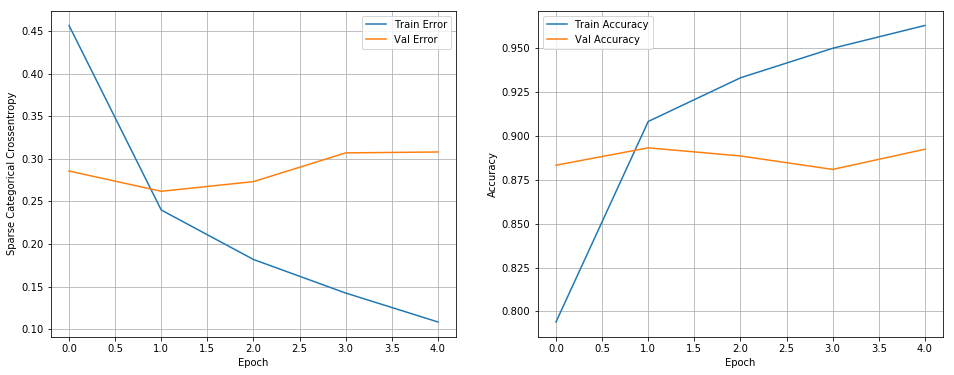

782/782 [==============================] - 2s 3ms/step - loss: 0.5507 - accuracy: 0.8663
Test Loss: 0.550712525844574
Test Accuracy: 0.8662800192832947


In [28]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
history = model.fit(x_train, y_train, validation_split=0.25, epochs= 5, batch_size=32)
show_loss_accuracy_evolution(hist)
results = model.evaluate(x_test, y_test, verbose=1)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

### Question 2: What happens if you reduce the size of the vocabulary `num_words`, compare results

### Compare with other ML algorithms

In [ ]:
from sklearn.linear_model import LogisticRegression
clr = LogisticRegression()
clr.fit(x_train, y_train)
val_acc = clr.score(x_test, y_test)
print('Test Accuracy: {}'.format(val_acc))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(max_depth=5, n_jobs=-1)
rfc.fit(x_train, y_train)
val_acc = rfc.score(x_test, y_test)
print('Test Accuracy: {}'.format(val_acc))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_jobs=-1)
rfc.fit(x_train, y_train)
val_acc = rfc.score(x_test, y_test)
print('Test Accuracy: {}'.format(val_acc))

In [ ]:
reviews = []
# training reviews
for ind in range(len(train_data)):
    sentence = train_data[ind]
    sentence_text = get_words(train_data[ind], int2word)
    reviews.append(sentence_text)
print('First training review: ', reviews[0])